In [1]:
import os
import sys
import re
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Astro 480 Labs and PSets\\Lab 4 - Data Reduction & Photometry'

In [2]:
sys.path.append('..\\..\\interacting_galaxies') # for laptop 
sys.path.append('..\\..\\Interacting Galaxies Project') # for desktop
from funcrefs import fnrefs as rfs
from funcrefs import convenience_functions as cf

import numpy as np
import astropy.units as u

import matplotlib.pyplot as plt
import astropy.visualization as vis

from astropy.io import fits
from astropy.wcs import WCS
import ccdproc as ccdp
from astropy.nddata import CCDData

Notes for Observation Shifts
- for ngc 2998 if the picture given looks weird it's probably the spectrum pic
- darks are the same length as images you want to reduce (but you can also add some together)
- create a table that lists file names, filter, exposure time, and kind of file
- manually check for correct settings by downloading and opening fits file (don't trust preview screen)
- keep original data as raw
- [ccd data reduction guide](https://ccdproc.readthedocs.io/en/latest/)
- no overscans on ARCSAT

## <b>Data Reduction</b>

#### <u>Bias & Overscan</u>

1. <b>Define the bias. Include both a description of what it looks like physically, why it occurs, and how we take it into account (how do we remove its effect on our data images?)</b>

    A bias is a 0-second blank photo that records noise coming from the lens.

2. <b>Why would we use more than one bias frame?</b>

    The more bias frames you have the better you can remove noisy data from the pure photometric data. 
    This is helpful for being more precise with your values.

3. <b>List the average value of each of your bias frames, as well as your final master bias.</b>

    See below.

4. <b>Define "overscan".</b>

    

5. <s><b>Skip 5 (ARCSAT has no overscan)</b></s>

In [3]:
files = []
print("Average Bias Values (for each file)")
for file in os.listdir('../../Interacting Galaxies Project/biases'):
    with fits.open('../../Interacting Galaxies Project/biases/' + file) as hdul:
        data = hdul[0].data
        print(f"{np.mean(data):.3f}")
        files.append(np.mean(data))
print(f"Standard Deviation: {np.std(files):.3f}")

bias = fits.open('../../Interacting Galaxies Project/biases/master_bias.fits')[0].data
print(f"\nMaster Bias avg: {np.mean(bias):.3f}")

Average Bias Values (for each file)
1292.332
1292.311
1292.364
1292.303
1292.327
1292.282
1292.422
1292.429
1292.397
1292.422
1292.411
1292.365
1292.391
Standard Deviation: 0.049

Master Bias avg: 1292.391


#### <u>Flat Fields</u>

6. <b>Which filters do you have flat fields for? List the flat field file names for each filter that you need. Do you have more flats than you need? Confirm that your flat fields have the same binning as your data.</b>

    Filters: g, H-$\alpha$, i, r. 
    
    I'm not sure if there's a minimum amount of flats to have but in my opinion it doesn't hurt to have more! There are 5 flats for each filter. 
    
    See below for file names and confirming binning.

7. <b>Why do we need flat fields for each filter we have used for observations?</b>

    Similar to biases, these help to remove noise in the raw photometric data but are helpful for specifically pinpointing noise more prevalent in the correlating filter. Biases are more general and pertain to the noise coming from the telescope itself, where flats are for noise coming from the atmosphere or other parts of the sky.

In [4]:
# printing out raw file names
for filter in ["g flats", "ha flats", "i flats", "r flats"]:
    nm = [file for file in os.listdir(os.path.relpath("../../Interacting Galaxies Project/flats/" + filter)) if file.startswith('domeflat')]

    print(f"\n[{filter}] ({len(nm)} files)")
    print("\n".join(nm))

# normalizing the stacked flats
norm_flat = { # only flats need to be normalized
    'g': rfs.normalize(rfs.create_stack('../../Interacting Galaxies Project/flats/g flats/', keyword='domeflat')),
    'ha': rfs.normalize(rfs.create_stack('../../Interacting Galaxies Project/flats/ha flats/', keyword='domeflat')),
    'i': rfs.normalize(rfs.create_stack('../../Interacting Galaxies Project/flats/i flats/', keyword='domeflat')),
    'r': rfs.normalize(rfs.create_stack('../../Interacting Galaxies Project/flats/r flats/', keyword='domeflat'))
}


[g flats] (5 files)
domeflat_g_001-2_050224.fits
domeflat_g_001_050224.fits
domeflat_g_001_050524.fits
domeflat_g_002_050524.fits
domeflat_g_003_050524.fits

[ha flats] (5 files)
domeflat_Ha_001-2_050224.fits
domeflat_Ha_001_050224.fits
domeflat_Ha_001_050524.fits
domeflat_Ha_002_050524.fits
domeflat_Ha_003_050524.fits

[i flats] (5 files)
domeflat_i_001-2_050224.fits
domeflat_i_001_050224.fits
domeflat_i_001_050524.fits
domeflat_i_002_050524.fits
domeflat_i_003_050524.fits

[r flats] (5 files)
domeflat_r_001-2_050224.fits
domeflat_r_001_050224.fits
domeflat_r_001_050524.fits
domeflat_r_002_050524.fits
domeflat_r_003_050524.fits


#### <u>Darks</u>

If your science images here are short, the dark current is extremely low and so we ignore it here. If you are taking longer images, or on instruments with lots of dark current, you can’t neglect this term of the noise in reduction. Make sure to take into account darks

In [5]:
dark = fits.open('../../Interacting Galaxies Project/darks/master_dark.fits')[0].data

#### Putting it all together (just to see how it looks)

In [6]:
ngc_g = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_g.fits')[0].data

ngc_ha = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_ha.fits')[0].data

ngc_i = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_i.fits')[0].data

ngc_r = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_r.fits')[0].data

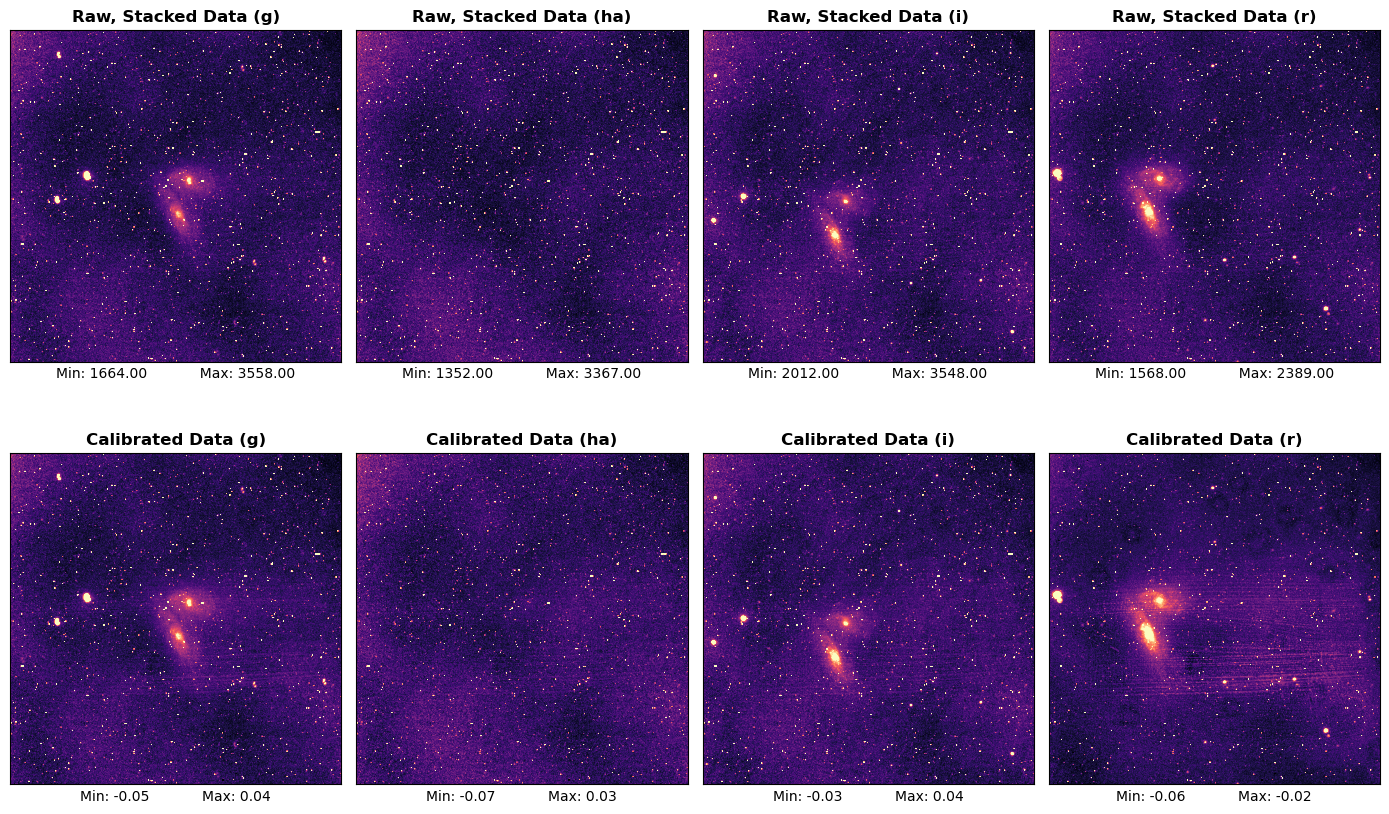

In [109]:
# for a 4x2 grid, swap the rows and columns, figsize, and the axs indices
fig, axs = plt.subplots(2, 4, figsize=(14, 9))

filters = ['g', 'ha', 'i', 'r']
ngc_data = [ngc_g, ngc_ha, ngc_i, ngc_r]

for i, (filter, data) in enumerate(zip(filters, ngc_data)):
    # Raw data
    vis_vmin, vis_vmax = np.percentile(data, [1, 99.6])
    axs[0, i].set_xlabel(f'Min: {vis_vmin:.2f}            Max: {vis_vmax:.2f}')
    norm = vis.ImageNormalize(data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    axs[0, i].imshow(data, cmap='magma', norm=norm, interpolation='hermite')
    axs[0, i].set_title(f'Raw, Stacked Data ({filter})', weight='bold')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])

    # Calibrated data
    calibrated_data = ((data - bias - dark) / norm_flat[filter]) #+ (norm_flat[filter]**-1)
    vis_vmin, vis_vmax = np.percentile(calibrated_data, [1, 99.6])
    norm = vis.ImageNormalize(calibrated_data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    axs[1, i].imshow(calibrated_data, cmap='magma', norm=norm, interpolation='hermite')
    axs[1, i].set_title(f'Calibrated Data ({filter})', weight='bold')
    axs[1, i].set_xlabel(f'Min: {vis_vmin:.2f}            Max: {vis_vmax:.2f}')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()

## <b>Data Analysis (Photometry)</b>

You now have images that are as close as we can get to what was emitted from our source. You can either use one of the broadband images from your project data or download the image from Canvas to use for this portion of the lab. It will provide an example for the different approaches to photometry you can then use for your project. (The next portion looks for point sources - if you use an image that has a diffuse image, like the nebulas, it might do some weird things for some of the options like DAOStarFinder. If you’re having trouble navigating that - just grab the image on canvas.)

We are going to use the [“photutils”](https://photutils.readthedocs.io/en/stable/) python package to measure the signal.

#### <u>The Sky</u>

We are going to be subtracting the sky on the fly as we use aperture photometry to calculate the flux of the stars in our field. If your primary science object is diffuse or extended just choose a stars in your field that aren’t overexposed/saturated as your object.

8. What drawbacks could exist from this method of sky subtraction?

9. Why does sky subtraction matter?

Identify the sources to perform photometry on in your image. DAOStarFinder is one 
method provided within photutils. Plot the stars found on top of your image. Adjust your parameters to select a smaller set of stars (Between 10-100ish. Depending on your image). Replot. Remove any “bad” stars from the sources array by hand (hot spots, stars on the edge, stars on the overscan)

10.  How many objects did you identify with DAOStarFinder? Look at your image. Do you think that’s a reasonable number? What did you change to adjust the number of stars detected? How many stars did you end up with?

Photutils provides many different kinds of apertures. We will use two here, but other cases (such as galaxies) might require apertures that aren’t round. First, use the “circular aperture” Choose your method and execute your aperture photometry. Review the output. Then plot your apertures on top of your image.  

11. Are you happy with your apertures? Why or why not? Save the list of sources for comparison.

Now we’re going to do the same thing, but instead of using just a circular aperture, we’re going to use annuli. This means you can specify a region for the star, and a nearby region for the sky. This allows us to use the sky that is close to the individual objects to subtract.

Pick your object aperture and note it in your Q12 answers. 
Pick your sky annulus minimum and maximum note it in your Q12 answers.

Now, run as above, except using the “CircularAnnulus” command. Use these two measurements of flux to remove the background from the originally measured flux, and print those results.

12. Make a plot comparing the measurements of the two different methods

Use PSF fitting to calculate the flux of the same set of sources you found with 
DAOstarfinder. Make sure to sky subtract

13. Make a plot comparing the PSF fitting output to the aperture output. Are they the same? Why or why not? 

14. What do you need to do differently for your science image? (For example - are you studying one point source, many point sources, or a diffuse object? What does that change?) 

15. Did you prefer PSF fitting or aperture photometry? Think of one situation that you think would be best for each method.